<a href="https://colab.research.google.com/github/jon-nowacki/Optimization-Models/blob/main/Transportation_Graph_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transportation Model with Graph Visualization
---

* optimization problems related to logistics
* visualize supply networks using NetworkX

# Initial Setup
---
Run these cells once to link google drive and importing the frameworks needed for this notebook

**Run this first**

This will install Pyomo and glpk solver

In [1]:
!pip install -q pyomo
!apt-get install -y -qq glpk-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.3 MB/s eta 0:00:00
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 120903 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected pac

**Importing libraries**

In [3]:
#pyomo framework
import numpy as np
from pyomo.environ import *
from pyomo.opt import SolverFactory

#networkx framework
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

# Transportation optimization

In [29]:
# create model
model=ConcreteModel(name='Transportation MIN COST')

# define variables
# distribution centers
model.distribution_centers = Set(initialize=["D1","D2","D3"], doc="distribution centers")
model.customers = Set(initialize=["C1","C2"], doc="customers")


# definint_parameters
model.distribution_capacity = Param(model.distribution_centers, initialize={"D1":20, "D2":40, "D3":50}, doc="capacities of each distribution center")
model.cust_demand = Param(model.customers, initialize={"C1":30, "C2":40}, doc="demand for each customer")

dist={
    ("D1", "C1") : 1,
    ("D2", "C1") : 1,
    ("D3", "C1") : 3,
    ("D1", "C2") : 2,
    ("D2", "C2") : 1,
    ("D3", "C2") : 2,
}
# define objective

model.distance = Param(model.distribution_centers, model.customers, initialize=dist, doc="distance in mile between centers and customers")

model.distribution_cost=Param(initialize=10, doc="distribution cost per mile")

model.shipment_quantity = Var(model.distribution_centers, model.customers, domain=NonNegativeIntegers, doc="quantitity shipped between dc and customer")

def transportation_cost(model, dc, customer):
  return model.distribution_cost * model.distance[dc, customer]

model.distance_cost = Param(model.distribution_centers, model.customers, rule=transportation_cost, doc="distribution cost per mile")

# solve

def supply_limit(model, dc):
  return sum(model.shipment_quantity[dc, customer] for customer in model.customers) <= model.distribution_capacity[dc]

model.supply = Constraint(model.distribution_centers, rule=supply_limit, doc="customer demand list constraint")


def demand_limit(model, customer):
  return sum(model.shipment_quantity[dc, customer] for dc in model.distribution_centers) >= model.cust_demand[customer]

model.demand = Constraint(model.customers, rule=demand_limit, doc="customer demand list constraint")

def objective_rule(model):
  return sum(model.distance_cost[dc, customer]*model.shipment_quantity[dc, customer] for dc in model.distribution_centers for customer in model.customers)

model.objective = Objective(rule=objective_rule, sense=minimize, doc="asdf")

SolverFactory('glpk',executable='/usr/bin/glpsol').solve(model).write()

# display results

model.shipment_quantity.display()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 800.0
  Upper bound: 800.0
  Number of objectives: 1
  Number of constraints: 5
  Number of variables: 6
  Number of nonzeros: 12
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1
      Number of created subproblems: 1
  Error rc: 0
  Time: 0.003632068634033203
# ----------------------------------------------------------
#   Solution Information
# -----------------------------------

# Supply Network Visualization

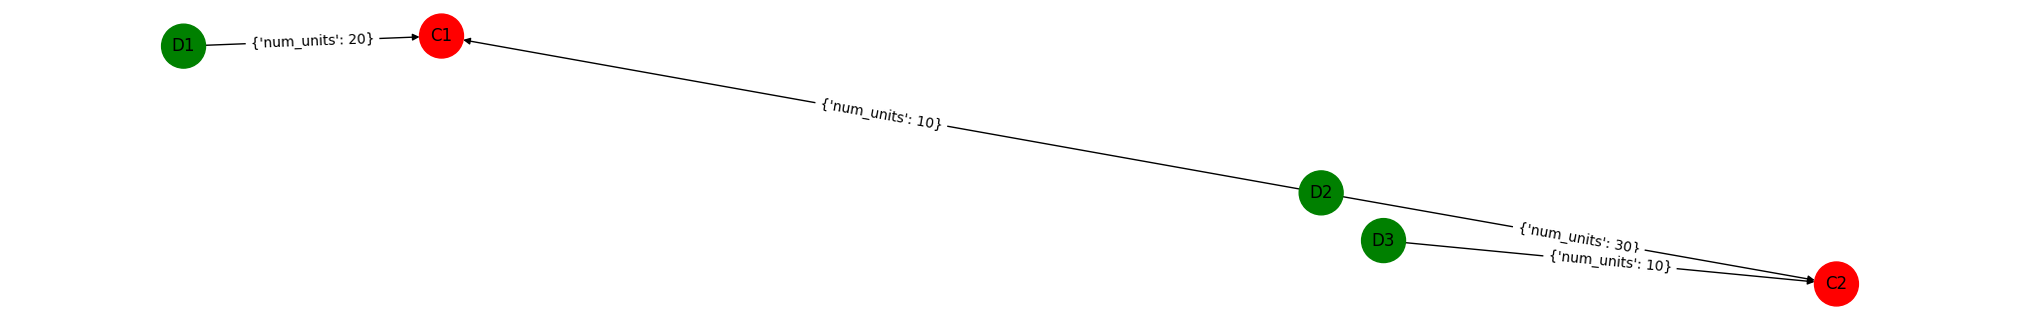

In [38]:
# empty network graph
G = nx.DiGraph() # nx is NetworkX, DiGraph is directional graph

# add nodes
G.add_nodes_from(["D1","D2","D3","C1","C2"]) # list of node names

# Colors of nodes, 1 color per node above
color_map=["green","green","green","red","red"]

# Add edges, nodes must already be definied. add_edge(Source, Destination, Attribute)
G.add_edge("D1","C1", num_units=20)
G.add_edge("D2","C1", num_units=10)
G.add_edge("D2","C2", num_units=30)
G.add_edge("D3","C2", num_units=10)

# Algorithym to determine node location. Attribute is a string here, but not in G.add_edge()
pos=nx.spring_layout(G,
                     weight="num_units" # attribute is a string here, not in G.add_edge().
                     )


nx.draw(G, # List of nodes
        pos, # Locations on nodes we created above
        with_labels=True, # display labels
        node_size=1000, # Diameter of nodes
        node_color=color_map) # our color map we already defined above

nx.draw_networkx_edge_labels( # layout edges
    G, # Graph
    pos # layout
    )
plt.show() # make the plot!
